# Module import

In [ ]:
!pip install torch==2.0.0 torchvision==0.15.1
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import warnings
import torch
import torchvision
from torchvision.utils import save_image
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch import nn
from d2l import torch as d2l

import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd
import numpy as np
import cv2


#Import data

In [ ]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [ ]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


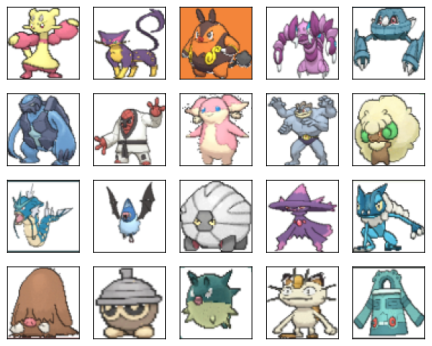

In [ ]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

##Pretrain the GAN model

### Generator

In [ ]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [ ]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

### Discriminator

In [ ]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [ ]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

### Train

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu(), pretrained_D=None):
    loss = nn.BCEWithLogitsLoss(reduction='sum')

    if pretrained_D is not None:
        # Load pretrained weights into the Discriminator
        net_D.load_state_dict(torch.load(pretrained_D))
        # Freeze the Discriminator parameters
        for param in net_D.parameters():
            param.requires_grad = False

    else:
        for w in net_D.parameters():
            nn.init.normal_(w, 0, 0.02)

    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)

    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)


    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.039, loss_G 7.379, 633.4 examples/sec on cuda:0


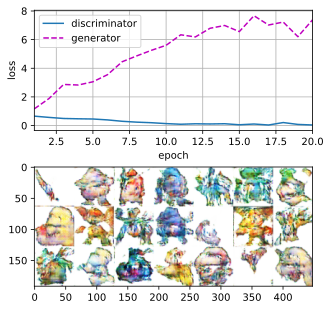

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

### FID score

In [ ]:
pip install clean-fid

In [ ]:
from cleanfid import fid
score = fid.compute_fid("../data/pokemon", "./GAN")

In [ ]:
score

186.55272002954257

### Custom dataset

#### GAN generated images

In [ ]:
#%cd GAN

# Check for GPU availability
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#for i in range(10000):
#  Z = torch.normal(0, 1, size=(1, latent_dim, 1, 1), device=device)
  # Normalize the synthetic data to N(0, 1)
#  fake_x = net_G(Z) / 2 + 0.5
#  fake_img = fake_x.cpu().detach()[0].squeeze()

  # Save the image tensor as a file
#  save_image(fake_img, f'fake_({i}).png')

#!cd ..
#!zip -r FAKE GAN

/content/GAN


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!unzip GAN.zip


#### Real images

In [ ]:
!mkdir REAL

In [ ]:
img_num = 0
# extract real images from the pokemon dataset
for X, _ in data_iter:
    for img in X:
       # Save the image tensor as a file
        save_image(img, f'./REAL/real_({img_num}).png')
        img_num += 1

## Train Discriminator

#### Custum datasets

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
      self.img_labels = dataframe
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
def showNineImgs(data):
  # Check if data was loaded without any problems
  labels_map = {
      0: "fake",
      1: "real",
  }
  figure = plt.figure(figsize=(4, 4))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(data), size=(1,)).item()
      img, label = data[sample_idx]
      img = img/2+0.5
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
  plt.show()

In [ ]:
image = read_image("./GAN/fake_(0).png")

In [ ]:
image.shape

torch.Size([3, 64, 64])

In [ ]:
img2 = read_image("./REAL/real_(0).png")
img2.shape

torch.Size([3, 64, 64])

In [ ]:
TRAIN_ANNO_PATH = "train_labels.csv"

train_paths_fake = list(glob('./GAN/*.png'))
print(len(train_paths_fake))

df_train_fake = pd.DataFrame(train_paths_fake)
df_train_fake.columns = ['path']
df_train_fake['label'] = 0
df_train_fake.head()

train_paths_real = list(glob('./REAL/*.png'))
print(len(train_paths_real))

df_train_real = pd.DataFrame(train_paths_real)
df_train_real.columns = ['path']
df_train_real['label'] = 1
df_train_real.head()

df_train = pd.concat((df_train_fake, df_train_real), axis = 0 )
print(df_train.shape)

df_train.to_csv(TRAIN_ANNO_PATH, index=False)

10000
40597
(50597, 2)


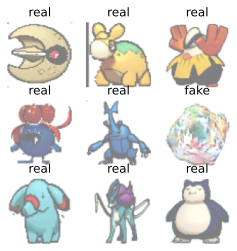

In [ ]:
dataset = CustomImageDataset(pd.read_csv(TRAIN_ANNO_PATH), "", transform=lambda img: img.type(torch.FloatTensor) / 255)
showNineImgs(dataset)

In [ ]:
# Calculate the sizes of the training, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for the training, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

### Pretrain previous discriminator

#### train

In [ ]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

In [ ]:
lr = 0.005
num_epochs = 20

for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
net_D = net_D.to(device)
net_D.train()
losses = []
val_losses = []
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(net_D.parameters(), lr=lr)

# Assuming train_loader provides batches of input data and corresponding labels
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize epoch loss
    for i, data in enumerate(train_loader, start=0):
        inputs, labels = data  # Get inputs and corresponding labels

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = net_D(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights based on gradients

        # Accumulate epoch loss
        epoch_loss += loss.item()

        # Optionally, print the loss
        if i % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

  # Calculate average epoch loss and store it
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Epoch Loss: {avg_epoch_loss:.4f}")

In [ ]:
# Plotting the loss
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


#### test

In [ ]:
# Load the trained model
#model = SimpleCNN()
#model.load_state_dict(torch.load('./drive/MyDrive/Github/COSE474_Term_Project/model_weights.pth'))
net_D.eval()

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net_D(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test dataset: {accuracy}')

In [ ]:
torch.save(model.state_dict(), 'net_D_pretrained.pth')

## Teach generator model using the discriminator

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, pretrained_D='net_D_pretrained.pth')

### CIFAKE Model

In [ ]:
# model from https://www.kaggle.com/code/muntasirfahimniloy/simple-cnn-on-cifake-90-acc

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # [32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [64, 16, 16]
        x = self.pool(F.relu(self.conv3(x)))    # [128, 8, 8]
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)     # dropout for regularization
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the weights of the model
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [ ]:
# Define the range of learning rates to try
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 20

# Collect validation losses for each learning rate
val_losses_per_lr = {}

for lr in learning_rates:

    model = SimpleCNN()
    model.apply(weights_init)
    model.to(device)
    model.train()
    losses = []
    val_losses = []
    criterion = nn.BCEWithLogitsLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Assuming train_loader provides batches of input data and corresponding labels
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Initialize epoch loss
        for i, data in enumerate(train_loader, start=0):
            inputs, labels = data  # Get inputs and corresponding labels

            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights based on gradients

            # Accumulate epoch loss
            epoch_loss += loss.item()

            # Optionally, print the loss
            if i % 200 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Calculate average epoch loss and store it
        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)

        if epoch % 10 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Average Epoch Loss: {avg_epoch_loss:.4f}")

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        # ... (same validation loop as before)
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data

                # Move inputs and labels to the GPU
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Print validation statistics
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, "
              f"Validation Accuracy: {accuracy:.2f}%")

        val_losses.append(val_loss / len(val_loader))

    val_losses_per_lr[lr] = val_losses

# Plotting
for lr, val_losses in val_losses_per_lr.items():
    plt.plot(val_losses, label=f'Learning Rate: {lr}')

plt.title('Validation Losses for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


Epoch [1/20], Batch [1/949], Loss: 0.6926
Epoch [1/20], Batch [201/949], Loss: 0.5633
Epoch [1/20], Batch [401/949], Loss: 0.5008
Epoch [1/20], Batch [601/949], Loss: 0.5633
Epoch [1/20], Batch [801/949], Loss: 0.4383
Epoch [1/20], Average Epoch Loss: 0.5095
Epoch [1/20], Validation Loss: 0.5179, Validation Accuracy: 79.62%
Epoch [2/20], Batch [1/949], Loss: 0.4070
Epoch [2/20], Batch [201/949], Loss: 0.5945
Epoch [2/20], Batch [401/949], Loss: 0.5008
Epoch [2/20], Batch [601/949], Loss: 0.5633
Epoch [2/20], Batch [801/949], Loss: 0.5008
Epoch [2/20], Validation Loss: 0.5179, Validation Accuracy: 79.62%
Epoch [3/20], Batch [1/949], Loss: 0.6258
Epoch [3/20], Batch [201/949], Loss: 0.4695
Epoch [3/20], Batch [401/949], Loss: 0.5633
Epoch [3/20], Batch [601/949], Loss: 0.4070
Epoch [3/20], Batch [801/949], Loss: 0.4383


KeyboardInterrupt: ignored

#### test the discriminator

In [ ]:

# test
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print validation statistics
accuracy = 100 * correct / total
print(f"test Accuracy: {accuracy:.2f}%")



#### Save the model

In [ ]:
torch.save(model.state_dict(), 'discriminator_weights.pth')